In [1]:
#Importing libraries
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation


import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.2.0'

In [3]:
#load data

(x_train, y_train), (x_test, y_test) = mnist.load_data()

#different classes model has to learn to differentiate
#code is written this way to make it generalizable to other datasets
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']


In [4]:
#defining characteristics of the dataset
img_rows = 28
img_cols = 28
channels = 1
num_classes = 10

#Normalizing Data
x_train = x_train / 255
x_test = x_test / 255

#Reshaping data into required format
x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

#One hot encoding labels into a more NN friendly format
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


The following model architecture is the baseline model I will be using. The model has been pre-trained to save time in another notebook called MNIST_baseline. 

In [5]:

def create_baseline_model():
    X_Input = Input((img_rows, img_cols, channels))
    X = Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X_Input)
    X = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X)
    X = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.2)(X)
    X = Flatten()(X)
    X = Dense(32)(X)
    X = Dropout(0.2)(X)
    X = Dense(32)(X)
    X = Dropout(0.2)(X)
    X = Dense(num_classes, activation='softmax')(X)
    
    model = Model(inputs = X_Input, outputs = X)
    return model

model = create_baseline_model()

model.load_weights(filepath='./baseline_model.hdf5')
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Check if model is imported correctly. Accuracy should be 0.981800019
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 0.9818


[0.0029318640008568764, 0.9818000197410583]

Finally, the next code cell implements the adversarial attack algorithm. What this does essentially is finds the loss function of the model with respect to the image, and instead of updating the image to minimize loss, the model updates the image to maximize loss.

In [6]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

Finally, we will generate adversarial examples! Right now, I will only generate adversarial examples for the first 3000 rows of the training set, but this is purely to save time. We will still be able to see a huge drop in accuracy.

In [7]:
preds = []
x_adversarial = np.zeros((3000, 28, 28, 1))

for i in range(3000):
    image = x_train[i]
    image_label = y_train[i]
    
    perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
    adversarial = image + perturbations * 0.1
    x_adversarial[i, :, :, :] = adversarial
    preds.append(model.predict(adversarial).argmax())

Now we will see how are model performed on the adversarial examples. We will also compare it to how it performs on regular examples. There is a drop from 98% to 23%, which is almost 75%!. Here we see the need to prevent such attacks, as in a few minutes, we were able to bring the model down on its knees.

In [8]:
#Let's see the accuracy of model against adversarial
model.evaluate(x_adversarial[0: 3000, :, :, :], y_train[0 : 3000, :])

94/94 [==============================] - 0s 1ms/step - loss: 0.1367 - accuracy: 0.2293


[0.13667051494121552, 0.2293333262205124]

In [9]:
#Let's see the accuracy of model against regular data to compare. The above value should be very low compared to this one.
model.evaluate(x_train[0: 3000, :, :, :], y_train[0 : 3000, :])

94/94 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 0.9890


[0.001836622366681695, 0.9890000224113464]

# Training on Adversarial Data
The first approach we will try is the standard approach of training on adversarial data. I will not be using pure adversarial data as I don't want the model to forget how to classify regular images!

In [10]:
ad_train = np.concatenate((x_adversarial, x_train[0 : 3000, :, :, :]))
ad_y_train = np.concatenate((y_train[0 : 3000, :],y_train[0 : 3000, :]))

In [11]:
ad_train.shape

(6000, 28, 28, 1)

In [12]:
ad_y_train.shape

(6000, 10)

Now we will train the model. When I was running experiments, I found something very interesting: if the epochs are set to 20, and then I try to implement adversarial attacks on the test set and evaluate, the model actually performs worse than otherwise. This means that the model is overfitting to adversarial examples, and hence is only memorizing some examples. Although overfitting happens for regular data as well, it is important to note that when training the model on regular data, the model didn't overfit even after 20 epochs, and the test accuracy was still going up. 

Conclusion: Adversarial Examples are extremely easy to overfit to. Hence, it won't be extremely effective.

In [13]:
model.fit(ad_train, ad_y_train, batch_size=32, epochs = 2)

Epoch 1/2
188/188 [==============================] - 1s 3ms/step - loss: 0.0276 - accuracy: 0.8448
Epoch 2/2
188/188 [==============================] - 1s 3ms/step - loss: 0.0141 - accuracy: 0.9203


In [14]:
model.evaluate(x_adversarial[0: 3000, :, :, :], y_train[0 : 3000, :])

94/94 [==============================] - 0s 1ms/step - loss: 0.0131 - accuracy: 0.9267


[0.013093532994389534, 0.9266666769981384]

In [15]:
test_preds = []
test_adversarial = np.zeros((3000, 28, 28, 1))

for i in range(3000):
    image = x_test[i]
    image_label = y_test[i]
    
    perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
    adversarial = image + perturbations * 0.1
    test_adversarial[i, :, :, :] = adversarial
    test_preds.append(model.predict(adversarial).argmax())

In [16]:
test_adversarial.shape

(3000, 28, 28, 1)

In [17]:
#So accuracy has increased to 61% from 20%. Major Improvement! But that's still not enough. Still 40% of the time, the model is horribly wrong.
model.evaluate(test_adversarial, y_test[0 : 3000, :])

94/94 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.5860


[0.07750704884529114, 0.5860000252723694]

In [18]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0050 - accuracy: 0.9727


[0.004953921306878328, 0.9726999998092651]

In [19]:
#Saving Model Weights
model.save("adv_trained_model.hdf5")

The good thing is that after training on the adversarial examples, the model has grown a tolerance towards them, and improves to 61%. However, we are stuck here now, since we can't train the model more, else it will overfit the training data and perform worse.

In [63]:
model = create_baseline_model()

model.load_weights(filepath='./baseline_model.hdf5')
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Check if model is imported correctly. Accuracy should be 0.981800019
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 920us/step - loss: 0.0029 - accuracy: 0.9818


[0.0029318640008568764, 0.9818000197410583]

In [21]:
anti_noise_preds = []
noise_adversarial = np.zeros((3000, 28, 28, 1))

for i in range(3000):
    image = x_test[i]
    image_label = y_test[i]
    
    perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
    adversarial = image + perturbations * 0.1
    adversarial = adversarial>0.3
    noise_adversarial[i, :, :, :] = adversarial
    anti_noise_preds.append(model.predict(adversarial).argmax())

In [22]:
model.evaluate(noise_adversarial, y_test[0 : 3000, :])

94/94 [==============================] - 0s 1ms/step - loss: 0.0146 - accuracy: 0.9140


[0.014571293257176876, 0.9139999747276306]

So it looks like denoising is amazing! It increases the accuracy to 91%. That's almost perfect - but now let's see how it holds against increased noise.

In [23]:
anti_noise_preds = []
noise_adversarial = np.zeros((3000, 28, 28, 1))
no_noise_adversarial = np.zeros((3000, 28, 28, 1))

for i in range(3000):
    image = x_test[i]
    image_label = y_test[i]
    
    perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
    adversarial = image + perturbations * 0.3
    no_noise_adversarial[i, :, :, :] = adversarial
    adversarial = adversarial>0.3
    noise_adversarial[i, :, :, :] = adversarial
    anti_noise_preds.append(model.predict(adversarial).argmax())

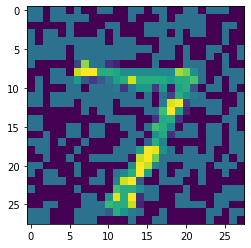

In [24]:
plt.imshow(no_noise_adversarial[0, :, :, :].reshape((img_rows, img_cols)))

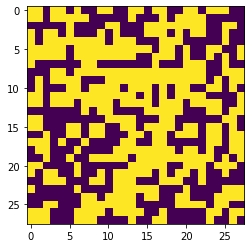

In [25]:
plt.imshow(noise_adversarial[0, :, :, :].reshape((img_rows, img_cols)))

In [26]:
model.evaluate(noise_adversarial, y_test[0 : 3000, :])

94/94 [==============================] - 0s 1ms/step - loss: 0.1768 - accuracy: 0.0473


[0.17678509652614594, 0.047333333641290665]

About 5 percent. That's horrible - increasing the noise by a little completely ruined the model's performance. Hence, although this binary thresholding is the best approach we currently have, it won't be good enough since a small change can ruin it. Now we see the need for a more robust system. As I have shown, using current techniques doesn't help much since it isn't robust.
Firstly, I will be trying out a filtering technique, which aims to identify and exclude adversarial examples from even enterring the model. The first filtering technique which was tried above was denoising, but we can see that this isn't particularly robust to different amounts of noise. Let's train a NN to predict whether or not a datapoint is adversarial. Then we can decline potentially harmful examples.

First thing to do is to generate the training and testing data for the model. I will try out different noise levels for the test dataset to see if the model generalizes.

In [27]:
adv_train = np.zeros((3000, 28, 28, 1))

adv_test = np.zeros((3000, 28, 28, 1))
y_adv_train = np.zeros((6000, 1))
y_adv_test = np.zeros((6000, 1))

for i in range(3000):
    image = x_train[i]
    image_label = y_train[i]
    
    perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
    
    image_test = x_test[i]
    image_label_test = y_test[i]
    
    perturbations_test = adversarial_pattern(image_test.reshape((1, img_rows, img_cols, channels)), image_label_test).numpy()

    if i > 1499:
        adversarial = image + perturbations * 0.1
        adv_train[i] = adversarial
        
        adversarial = image_test + perturbations_test * 0.1
        adv_test[i] = adversarial
        
    else:
        adversarial = image + perturbations * 0.3
        adv_train[i] = adversarial
        
        adversarial = image_test + perturbations_test * 0.4
        adv_test[i] = adversarial
    
    y_adv_train[i] = 1
    y_adv_test[i] = 1
    
fin_adv_train = np.concatenate((adv_train, x_train[3000 : 6000, :, :, :]))

fin_adv_test = np.concatenate((adv_test, x_test[3000 : 6000, :, :, :]))

In [28]:
print("Shapes of final data are ")
print((fin_adv_train.shape, y_adv_train.shape, fin_adv_test.shape, y_adv_test.shape))

Shapes of final data are 
((6000, 28, 28, 1), (6000, 1), (6000, 28, 28, 1), (6000, 1))


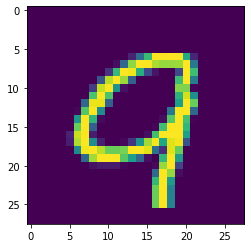

In [29]:
#checking to see if data is as desired.
plt.imshow(fin_adv_train[3000, :, :, :].reshape(28, 28))

In [30]:
def adv_classifier():
    X_Input = Input((img_rows, img_cols, channels))
    X = Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X_Input)
    X = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.2)(X)
    X = Flatten()(X)
    X = Dense(32)(X)
    X = Dropout(0.2)(X)
    X = Dense(1, activation='sigmoid')(X)
    
    adv_model = Model(inputs = X_Input, outputs = X)
    return adv_model

In [31]:
adv_model = adv_classifier()
adv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
adv_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                8224

In [32]:
history = adv_model.fit(fin_adv_train, y_adv_train, batch_size=32, epochs=10)

Epoch 1/10
188/188 [==============================] - 1s 3ms/step - loss: 0.1655 - accuracy: 0.9345
Epoch 2/10
188/188 [==============================] - 1s 3ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 3/10
188/188 [==============================] - 1s 3ms/step - loss: 3.7465e-04 - accuracy: 1.0000
Epoch 4/10
188/188 [==============================] - 1s 3ms/step - loss: 1.8127e-04 - accuracy: 1.0000
Epoch 5/10
188/188 [==============================] - 1s 3ms/step - loss: 7.9648e-05 - accuracy: 1.0000
Epoch 6/10
188/188 [==============================] - 1s 3ms/step - loss: 7.0082e-05 - accuracy: 1.0000
Epoch 7/10
188/188 [==============================] - 1s 3ms/step - loss: 5.0723e-05 - accuracy: 1.0000
Epoch 8/10
188/188 [==============================] - 1s 3ms/step - loss: 3.0002e-05 - accuracy: 1.0000
Epoch 9/10
188/188 [==============================] - 1s 3ms/step - loss: 2.6075e-05 - accuracy: 1.0000
Epoch 10/10
188/188 [==============================] - 1s 3ms/step - los

In [33]:
adv_model.evaluate(fin_adv_test, y_adv_test)

188/188 [==============================] - 0s 2ms/step - loss: 8.4749e-06 - accuracy: 1.0000


[8.47487444843864e-06, 1.0]

In [34]:
a = adv_model.predict(fin_adv_test)

In [35]:
a

array([[1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       ...,
       [1.3129377e-06],
       [2.1377024e-05],
       [6.4337117e-05]], dtype=float32)

In [36]:
#before adding model safecatch
model.evaluate(fin_adv_test, y_test[0 : 6000, :])

188/188 [==============================] - 0s 2ms/step - loss: 0.0861 - accuracy: 0.5338


[0.08614670485258102, 0.5338333249092102]

In [113]:
#adding model safecatch
model_safe = adv_model.predict(fin_adv_test)
correct = 0
counter = 0
for i in range(len(model_safe)):
    if model_safe[i] > 0.5:
        pass
    else:
        mod_pred = model.predict(fin_adv_test[i, :, :, :].reshape(-1, 28, 28, 1)).argmax()
        if mod_pred == y_test[i].argmax():
            correct += 1
        counter += 1
print('accuracy = ' + str(correct / counter))

accuracy = 0.9796666666666667


We can see that the model's accuracy has gone back up. The reason for this is that our model for filtering adversarial examples was very good. The problem is that we now have to run 2 models instead of 1, and in many applications, this is too slow.

In [50]:
!pip3 install foolbox==3.0.0b1

     |████████████████████████████████| 1.6 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 451 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 2.3 MB/s eta 0:00:011
You should consider upgrading via the '/Users/yush/anaconda3/bin/python -m pip install --upgrade pip' command.


In [51]:
import foolbox as fb

In [52]:
preprocessing = dict()
bounds = (0, 1)
fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [193]:
images, labels = fb.utils.samples(fmodel, dataset='mnist', batchsize=20)

In [194]:
fb.utils.accuracy(fmodel, images, labels)

0.949999988079071

In [195]:
#attack = fb.attacks.LinfDeepFoolAttack()
attack = fb.attacks.LinfPGD()
epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]

In [196]:
#raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=-1)
_, advs, success = attack(fmodel, images, labels, epsilons=epsilons)

In [220]:
success

<tf.Tensor: shape=(8, 20), dtype=bool, numpy=
array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False],
       [False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False],
       [ True, False,  True,  True,  True, False,  True,  True,  True,
         True, False,  True,  True,  True, False, False, False,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  

In [206]:
advss = np.array(advs)

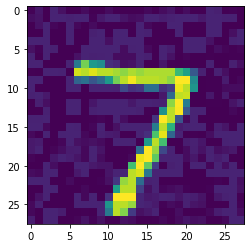

In [241]:
plt.imshow(advss[4, 0, :, :, :].reshape(28, 28))

In [216]:
advsss = advss.reshape(20*8, 28, 28, 1)
ad_labls = np.zeros((160,))
ad_labls[80 : 160] = np.ones((80,))

In [238]:
adv_model.evaluate(advsss, ad_labls) 
#Extremely bad filtering model against different type of attack

5/5 [==============================] - 0s 1ms/step - loss: 4.7090 - accuracy: 0.5000


[4.709028720855713, 0.5]

In [190]:
raw_np = raw.numpy()
raw_np.shape
imagess = images.numpy()
labelss = tf.keras.utils.to_categorical(labels.numpy(), num_classes)
count = 0
for i in range(20):
    pred = model.predict(raw_np[i, :, :, :].reshape(-1, 28, 28, 1)).argmax()
    if pred == labels[i]:
        count += 1
print("Accuracy is " + str(count / 20))
is_adv_try = is_adv.numpy().astype('int')
adv_model.evaluate(raw_np, np.ones((20,)))

(20, 28, 28, 1)

After this experiment, we can see that this filtering model is robust to different noise levels, but not very robust to different methods of attacks. We can see that against another gradient based attack, our filtering model was only able to filter out 80% of images. The other 20% still got through, meaning that a hacker may have to now try 4-5 attacks for atleast 1 to work. However, this is also not safe enough, since the model (once the image passes the filter), is guaranteed to get it wrong. 

Although we can use this as a filtering step when our application permits, we need a better approach.

Now I will try to normalize all of the inputs to the layers of the neural network. Maybe, by standardizing inputs, we can reduce the impact a single pixel has, and hopefully make such models less suceptible.

In [242]:
from tensorflow.keras.layers import BatchNormalization

In [252]:
#Adding BatchNormalization After every input
def create_batchnorm_model():
    X_Input = Input((img_rows, img_cols, channels))
    X = Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X_Input)
    X = BatchNormalization()(X)
    X = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X)
    X = BatchNormalization()(X)
    X = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    X = Flatten()(X)
    X = Dense(32)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    X = Dense(32)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    X = Dense(num_classes, activation='softmax')(X)
    
    model = Model(inputs = X_Input, outputs = X)
    return model

In [253]:
batch_model = create_batchnorm_model()
batch_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
batch_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 32)        320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 10, 10, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
batch_normalization_19 (Batc (None, 4, 4, 64)          256       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 1, 64)          0   

In [254]:
history = batch_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data = (x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0160 - accuracy: 0.8938 - val_loss: 0.0046 - val_accuracy: 0.9701
Epoch 2/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0068 - accuracy: 0.9565 - val_loss: 0.0037 - val_accuracy: 0.9758
Epoch 3/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0055 - accuracy: 0.9641 - val_loss: 0.0032 - val_accuracy: 0.9794
Epoch 4/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0048 - accuracy: 0.9690 - val_loss: 0.0032 - val_accuracy: 0.9789
Epoch 5/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0042 - accuracy: 0.9726 - val_loss: 0.0030 - val_accuracy: 0.9811
Epoch 6/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0039 - accuracy: 0.9748 - val_loss: 0.0029 - val_accuracy: 0.9807
Epoch 7/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0035 - accuracy: 0.9776 - val_loss: 0.0028 - val_ac

In [255]:
#Let's just double check to make sure we haven't decreased model accuracy - Generally, this shouldn't happen, although the large number of Batch Normalization layers might have an impact.
print("Original Model's Accuracy is ")
model.evaluate(x_test, y_test)
print()
print("Batch Normalization Model's accuracy is ")
batch_model.evaluate(x_test, y_test)

Original Model's Accuracy is 
313/313 [==============================] - 0s 970us/step - loss: 0.0029 - accuracy: 0.9818

Batch Normalization Model's accuracy is 
313/313 [==============================] - 1s 2ms/step - loss: 0.0021 - accuracy: 0.9872


[0.002098589204251766, 0.9872000217437744]

The good thing is that Batch Norm has not decreased model accuracy, rather slightly increased it - although it is a small change and won't help much in performance.
Now let's repeat the exercise to fool this model.

In [277]:
def adversarial_pattern_m(model_t, image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model_t(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [257]:
preds = []
x_adversarial = np.zeros((3000, 28, 28, 1))

for i in range(3000):
    image = x_train[i]
    image_label = y_train[i]
    
    perturbations = adversarial_pattern_m(batch_model, image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
    adversarial = image + perturbations * 0.1
    x_adversarial[i, :, :, :] = adversarial
    preds.append(batch_model.predict(adversarial).argmax())

In [267]:
#Let's hope that the model is more robust
batch_model.evaluate(x_adversarial[0: 3000, :, :, :], y_train[0 : 3000, :])

94/94 [==============================] - 0s 2ms/step - loss: 0.1863 - accuracy: 0.0000e+00


[0.18634691834449768, 0.0]

In [268]:
#Saving Model Weights
batch_model.save("batch_model.hdf5")

It turns out that Batch Normalization actually hurts the model. The reason for this must be that the model is used to inputs being normalized appropriately using BatchNorm, but adversarial examples are not normalized properly and so do worse.

Next let's see if increasing the dropout a lot helps in reducing the dependence on each neuron, and makes the models more robust. I will be increasing dropout by 3 - 4 times.

In [274]:
#Increasing Dropout
def dropout_inc_model():
    X_Input = Input((img_rows, img_cols, channels))
    X = Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X_Input)
    X = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X)
    X = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.8)(X)
    X = Flatten()(X)
    X = Dense(32)(X)
    X = Dropout(0.6)(X)
    X = Dense(32)(X)
    X = Dropout(0.4)(X)
    X = Dense(num_classes, activation='softmax')(X)
    
    model = Model(inputs = X_Input, outputs = X)
    return model

In [275]:
d_model = dropout_inc_model()
d_model.compile('adam', loss='mse', metrics=['accuracy'])
d_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 10, 10, 32)        320       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 64)                0   

In [276]:
history = d_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data = (x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0643 - accuracy: 0.4692 - val_loss: 0.0285 - val_accuracy: 0.8567
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0481 - accuracy: 0.6383 - val_loss: 0.0182 - val_accuracy: 0.9051
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0436 - accuracy: 0.6799 - val_loss: 0.0150 - val_accuracy: 0.9158
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0406 - accuracy: 0.7053 - val_loss: 0.0126 - val_accuracy: 0.9294
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0385 - accuracy: 0.7241 - val_loss: 0.0115 - val_accuracy: 0.9300
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0375 - accuracy: 0.7354 - val_loss: 0.0110 - val_accuracy: 0.9347
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0356 - accuracy: 0.7509 - val_loss: 0.0102 - val_accuracy:

In [279]:
preds = []
x_adversarial = np.zeros((3000, 28, 28, 1))

for i in range(3000):
    image = x_train[i]
    image_label = y_train[i]
    
    perturbations = adversarial_pattern_m(d_model, image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
    adversarial = image + perturbations * 0.1
    x_adversarial[i, :, :, :] = adversarial
    preds.append(d_model.predict(adversarial).argmax())

In [296]:
d_model.evaluate(x_adversarial[0: 3000, :, :, :], y_train[0:3000, :])

94/94 [==============================] - 0s 1ms/step - loss: 0.0240 - accuracy: 0.8497


[0.023957913741469383, 0.8496666550636292]

Turns out that adding high amounts of dropout didn't help at all. This might be because of the small model, but this will generalize to larget models as well, in that increasing dropout may help performance a little, but not enough to make them secure.

In [299]:
def dropout_test_model():
    X_Input = Input((img_rows, img_cols, channels))
    X = Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X_Input)
    X = Dropout(0.4)(X, training=True)   #Extra block added
    X = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X)
    X = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.4)(X, training=True)
    X = Flatten()(X)
    X = Dense(32)(X)
    X = Dropout(0.2)(X, training=True)
    X = Dense(32)(X)
    X = Dropout(0.05)(X, training=True)
    X = Dense(num_classes, activation='softmax')(X)
    
    model = Model(inputs = X_Input, outputs = X)
    return model

In [300]:
d_model = dropout_test_model()
d_model.compile('adam', loss='mse', metrics=['accuracy'])
d_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 10, 10, 32)        320       
_________________________________________________________________
dropout_41 (Dropout)         (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 1, 1, 64)          0  

In [301]:
history = d_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data = (x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0262 - accuracy: 0.8164 - val_loss: 0.0163 - val_accuracy: 0.8916
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0139 - accuracy: 0.9082 - val_loss: 0.0123 - val_accuracy: 0.9198
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0117 - accuracy: 0.9241 - val_loss: 0.0108 - val_accuracy: 0.9304
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0105 - accuracy: 0.9323 - val_loss: 0.0097 - val_accuracy: 0.9383
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0097 - accuracy: 0.9374 - val_loss: 0.0092 - val_accuracy: 0.9411
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0092 - accuracy: 0.9413 - val_loss: 0.0087 - val_accuracy: 0.9460
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0087 - accuracy: 0.9447 - val_loss: 0.0089 - val_accuracy:

In [302]:
d_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0069 - accuracy: 0.9556


[0.006904025096446276, 0.9556000232696533]

In [304]:
preds = []
x_adversarial = np.zeros((3000, 28, 28, 1))

for i in range(3000):
    image = x_train[i]
    image_label = y_train[i]
    
    perturbations = adversarial_pattern_m(d_model, image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
    adversarial = image + perturbations * 0.1
    x_adversarial[i, :, :, :] = adversarial
    preds.append(d_model.predict(adversarial).argmax())

In [305]:
d_model.evaluate(x_adversarial[0: 3000, :, :, :], y_train[0:3000, :])

94/94 [==============================] - 0s 1ms/step - loss: 0.0491 - accuracy: 0.6870


[0.04910464957356453, 0.6869999766349792]

For image models, dropout in the convolutional layer is very important.
Increasing dropout as much as possible will make the model more robust.

Previous dropout score - 0 / 0.4 / 0.2 / 0.05
0.4156666696071625

Current Dropout Score - 0.4 / 0.4 / 0.2 / 0.05
0.6869999766349792

These experiments show that increasing the dropout increases score a lot.

However, there is a tradeoff - Increasing dropout too much prevents the model from learning the data properly, and hence model performs poorly. Lower dropout, and adversarial attacks are more successful. 

Now let's run a grid search for searching all values of dropout in the model.

In [306]:
def dropout_grid_search(d1, d2, d3):
    X_Input = Input((img_rows, img_cols, channels))
    X = Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X_Input)
    X = Dropout(d1)(X, training=True)   #Extra block added
    X = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X)
    X = Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(d2)(X, training=True)
    X = Flatten()(X)
    X = Dense(32)(X)
    X = Dropout(d3)(X, training=True)
    X = Dense(32)(X)
    X = Dropout(0.05)(X, training=True)
    X = Dense(num_classes, activation='softmax')(X)
    
    model = Model(inputs = X_Input, outputs = X)
    return model

In [ ]:
# D1 best value = 0.45
# D2 best value = 0.3
# D3 best value = 0.075

In [340]:
fin_d_model = dropout_grid_search(0.45, 0.3, 0.075)
fin_d_model.compile('adam', loss='mse', metrics=['accuracy'])
history = fin_d_model.fit(x_train, y_train, batch_size=32, epochs=15, validation_data = (x_test, y_test))

Epoch 1/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0226 - accuracy: 0.8431 - val_loss: 0.0125 - val_accuracy: 0.9163
Epoch 2/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0115 - accuracy: 0.9246 - val_loss: 0.0096 - val_accuracy: 0.9393
Epoch 3/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0094 - accuracy: 0.9384 - val_loss: 0.0086 - val_accuracy: 0.9448
Epoch 4/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0086 - accuracy: 0.9452 - val_loss: 0.0078 - val_accuracy: 0.9486
Epoch 5/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0081 - accuracy: 0.9477 - val_loss: 0.0080 - val_accuracy: 0.9475
Epoch 6/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0075 - accuracy: 0.9519 - val_loss: 0.0067 - val_accuracy: 0.9552
Epoch 7/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0073 - accuracy: 0.9533 - val_loss: 0.0070 - val_accuracy:

In [341]:
fin_d_model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 0.9646


[0.005549668334424496, 0.9646000266075134]

In [343]:
fin_d_model.evaluate(x_adversarial[0: 3000, :, :, :], y_train[0:3000, :])

94/94 [==============================] - 0s 1ms/step - loss: 0.0315 - accuracy: 0.7937


[0.03149035573005676, 0.793666660785675]

The model is excellent against adversarial examples. Let's also increase noise to 20%.

In [345]:
fin_d_model.evaluate(x_adversarial[0: 3000, :, :, :], y_train[0:3000, :])

94/94 [==============================] - 0s 1ms/step - loss: 0.0897 - accuracy: 0.4267


[0.08965112268924713, 0.4266666769981384]

In [346]:
#Saving model weights
fin_d_model.save("dropout_model.hdf5")

Accuracy has gone down, quite a bit, but this is still much better than other techniques which went down to 15% or less.
Combining this with other approaches might be extremely effective against adversarial examples.

In [344]:
preds = []
x_adversarial = np.zeros((3000, 28, 28, 1))

for i in range(3000):
    image = x_train[i]
    image_label = y_train[i]
    
    perturbations = adversarial_pattern_m(fin_d_model, image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
    adversarial = image + perturbations * 0.2
    x_adversarial[i, :, :, :] = adversarial
    preds.append(fin_d_model.predict(adversarial).argmax())

In [336]:
#d1s = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
#d2s = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
d3s = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

n_accuracy = []
a_accuracy = []

for d3 in d3s:
    print("Training for dropouts   " + str(d3))
    d_model = dropout_grid_search(0.45, 0.3, d3)
    d_model.compile('adam', loss='mse', metrics=['accuracy'])
    history = d_model.fit(x_train, y_train, batch_size=32, epochs=15, validation_data = (x_test, y_test), verbose=0)

    
    preds = np.zeros(1000)
    x_adversarial = np.zeros((1000, 28, 28, 1))
    ys = np.zeros(1000)
    for i in range(1000):
        image = x_train[i]
        image_label = y_train[i]

        perturbations = adversarial_pattern_m(d_model, image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
        adversarial = image + perturbations * 0.1
        x_adversarial[i, :, :, :] = adversarial

        preds[i] = d_model.predict(adversarial).argmax()
        ys[i] = y_train[i].argmax()

    a_accuracy.append((ys == preds).sum() / 1000)
    n_accuracy.append(d_model.evaluate(x_test, y_test)[1])


Training for dropouts   0.05
313/313 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 0.9615
Training for dropouts   0.1
313/313 [==============================] - 0s 1ms/step - loss: 0.0063 - accuracy: 0.9598
Training for dropouts   0.15
313/313 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.9560
Training for dropouts   0.2
313/313 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9605
Training for dropouts   0.25
313/313 [==============================] - 0s 1ms/step - loss: 0.0067 - accuracy: 0.9581
Training for dropouts   0.3
313/313 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 0.9541


In [337]:
n_accuracy, a_accuracy

([0.9614999890327454,
  0.9598000049591064,
  0.9559999704360962,
  0.9605000019073486,
  0.9581000208854675,
  0.9541000127792358],
 [0.762, 0.829, 0.57, 0.729, 0.639, 0.627])

In [338]:
tot = []
for i in range(len(n_accuracy)):
    tot.append(n_accuracy[i] + a_accuracy[i])
tot

[1.7234999890327454,
 1.7888000049591064,
 1.525999970436096,
 1.6895000019073487,
 1.5971000208854675,
 1.5811000127792358]